# Подготовка данных

In [1]:
#установка библиотек

!pip install openpyxl xlsxwriter xlrd -q
!pip install catboost -q

import pandas as pd
import seaborn as sns
import sklearn
import xgboost as xgb
import catboost

In [2]:
#установка модулей

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt

In [3]:
#константы

RANDOM_STATE = 42
TEST_SIZE = 0.25
DENSITY = 0.877
MOLAR_MASS_ACID = 282.5

In [4]:
#Подготовка тренировочных данных

train = pd.read_excel('train.xlsx')
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10162 entries, 0 to 10161
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        10162 non-null  float64
 1   square      10162 non-null  float64
 2   start_time  10162 non-null  float64
 3   substance   9225 non-null   object 
dtypes: float64(3), object(1)
memory usage: 317.7+ KB


,time,square,start_time,substance
0,1.578314,30.962362,1.490339,и5
1,1.629458,70.300926,1.605952,н5
2,1.653532,6478.212402,1.639873,HDMS
3,1.771930,1056.017090,1.736610,HDMS
4,1.798921,140.062958,1.791436,и6




*   Все типы данных столбцах соответствуют действительности;
*   В данных имеются пропуски. Это неидентифицированные пики и их нужно просто удалить.



In [5]:
#удаление пропусков в данных
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9225 entries, 0 to 10161
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        9225 non-null   float64
 1   square      9225 non-null   float64
 2   start_time  9225 non-null   float64
 3   substance   9225 non-null   object 
dtypes: float64(3), object(1)
memory usage: 360.4+ KB


In [6]:
#проверка на дубликаты
train.duplicated().sum()

0

Явных дубликатов в данных нет.

# Исследовательский анализ данных

In [7]:
def hist_box(data, column):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для "{column}"')
    sns.histplot(data[column], color='MediumPurple')
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца {column}')
    plt.title(f'Диаграмма размаха для {column}')
    sns.boxplot(x=data[column], color='Indigo')

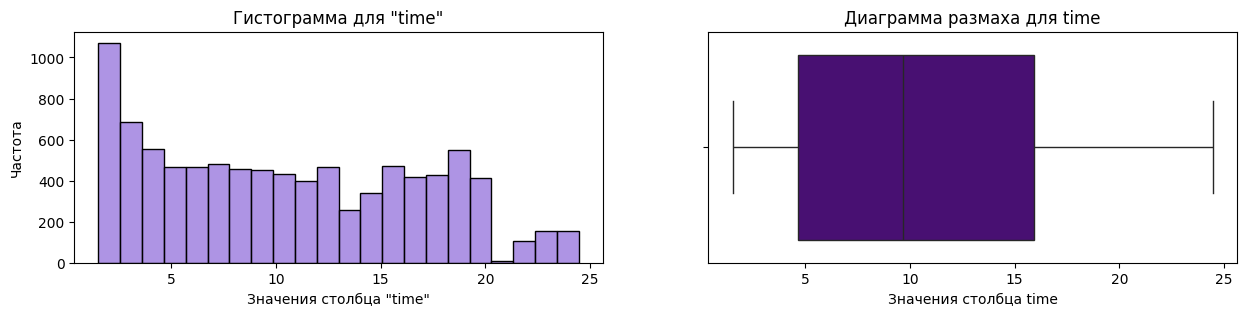

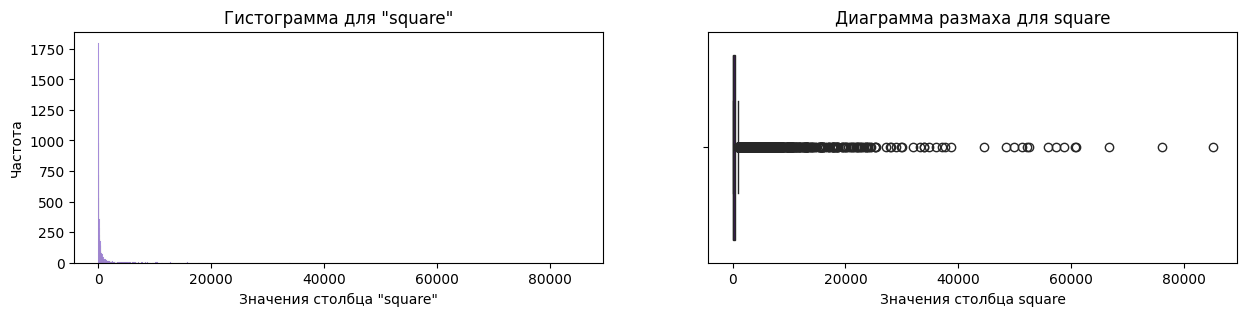

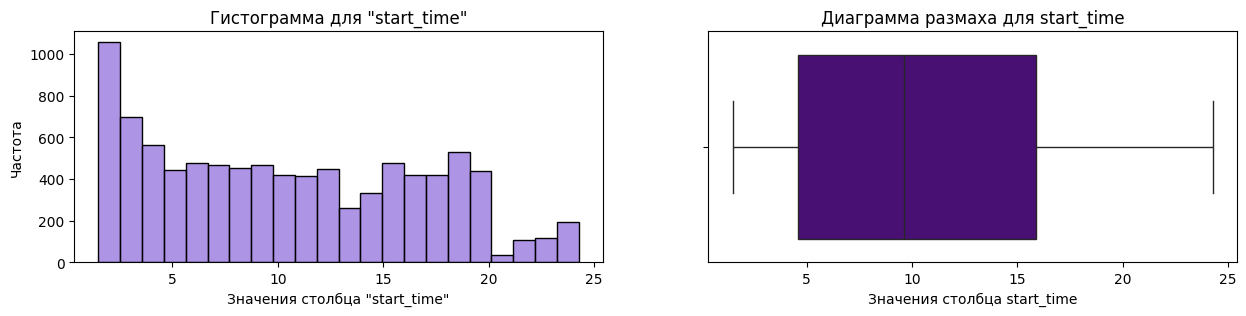

In [8]:
num_col = ['time', 'square', 'start_time']

for name in num_col:
    hist_box(train, name)

- аномальных значений признаков не наблюдается;
- данные распределены не нормально, что соотвествует сути данных.

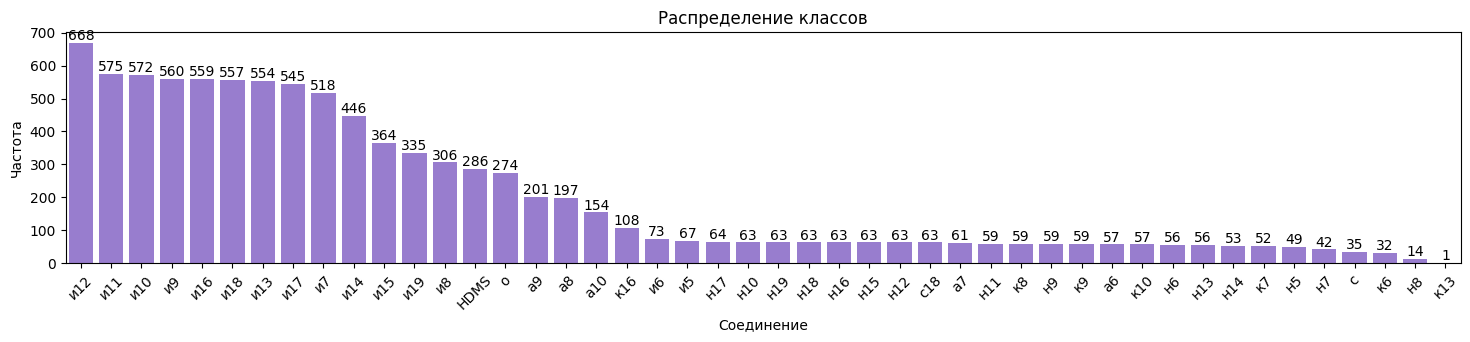

In [9]:
plt.figure(figsize=(18,3))
ax = sns.barplot(train.groupby('substance')['time'].count().sort_values(ascending=False), color='MediumPurple')
ax.bar_label(ax.containers[0], fontsize=10);
plt.title('Распределение классов')
plt.xticks(rotation=45)
plt.xlabel('Соединение')
plt.ylabel('Частота')
plt.show()

Наблюдается несбалансированность классов. Поэтому в качестве метрики для моделей будем использовать f1-score с макро-усреднением, поскольку нам важны все классы.

# Обучение моделей

In [10]:
#разбиение на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(train.drop(['substance', 'square'], axis=1),
                                                    train['substance'],
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE)

Кодирование целевого признака проводить не будем, поскольку нам нужно, чтобы модель размечала данные именно с такими наименованиями классов, как они представлены в тренировочном датасете.

In [11]:
#подготовка пайплайна для перебора гиперпараметров модели

pipe_final = Pipeline([
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_distributions = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 21)
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 150]
    },
    {
        'models': [XGBClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6)
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 6)
    },
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE,
                                      learning_rate=0.1,
                                      verbose=False)]
    }]

In [12]:
#подготовка пайплайна для нахождения лучшей модели

model = GridSearchCV(
    pipe_final,
    param_grid=param_distributions,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
)

In [13]:
model.fit(X_train, y_train)
print('Метрика для лучшей модели:\n', round(model.best_score_, 3))
print('\nЛучшая модель и её параметры:\n\n', model.best_params_)

Метрика для лучшей модели:
 0.913

Лучшая модель и её параметры:

 {'models': KNeighborsClassifier(n_neighbors=3), 'models__n_neighbors': 3}


In [14]:
y_pred = model.best_estimator_.predict(X_test)
round(f1_score(y_test, y_pred, average='macro'), 3)

0.936

# Расчет каталитических характеристик эксперимента

In [15]:
#создание словаря со всеми идентифицируемыми соединениями

substances = {'substance' : ['н5', 'н6', 'н7','н8','н9','н10','н11','н12','н13','н14','н15','н16','н17','н18','н19',
                             'и5', 'и6', 'и7','и8','и9','и10','и11','и12','и13','и14','и15','и16','и17','и18','и19',
                             'к6', 'к7', 'к8', 'к9', 'к10', 'к11', 'к12', 'к13', 'к14', 'к15', 'к16', 'к17', 'о', 'с', 'л', 'лл', 'а',
                             'а6', 'а7', 'а8', 'а9', 'а10', 'с18'],
              'count_C' : [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                           5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                           9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 21, 21, 21, 23,
                           6, 7, 8, 9, 10, 18],
              'molar_mass' : [72, 86, 100, 114, 128, 142, 156, 170, 184, 198, 212, 226, 240, 254, 268,
                              72, 86, 100, 114, 128, 142, 156, 170, 184, 198, 212, 226, 240, 254, 268,
                              128, 130, 144, 158, 172, 186, 200, 214, 228, 242, 256, 270, 284, 282, 280, 278, 312,
                              78, 92, 106, 120.2, 134, 270.5]
              }

activity = pd.DataFrame(index =['Конверсия', 'н-алканы', 'изо-алканы', 'ЖК', 'ароматика', 'спирт', '18_17'])

moles = pd.DataFrame()
masses = pd.DataFrame()

In [16]:
n = int(input('Количество отобранных точек в эксперименте: '))

Количество отобранных точек в эксперименте: 7


In [17]:
probes = pd.read_excel('experiment.xlsx', sheet_name='liquid')

In [18]:
#Классификация соединений выбранной моделью

for i in range(n):
    df_pred = pd.read_excel('experiment.xlsx', sheet_name=str(i+1))
    X_pred = df_pred.drop(['square'], axis=1)
    substance_pred = model.best_estimator_.predict(X_pred)
    df_pred['substance'] = substance_pred

    #создание датафрейма с веществами для дальнейшего расчета
    data = pd.DataFrame(substances)

    #подсчет общей площади для каждого соединения и объединение с датафреймом для расчета
    sum_square = df_pred.groupby('substance')['square'].sum()
    data = data.join(sum_square, how='left', on='substance', lsuffix='_1', rsuffix='_2')
    data = data.fillna(0)

    #Расчет нормированной площади
    data['norm_square'] = data['square'] / data['count_C']

    #Расчет мольной доли каждого соединения
    data['molar_fraction'] = data['norm_square'] * 100 / sum(data['norm_square'])

    #Расчет параметра, необходимого для дальнейшего расчета концентрации
    sum_m_w = sum(data['molar_mass'] * data['molar_fraction'])

    #Расчет концентрации соединения в г/моль
    data['concentration'] = data['molar_fraction'] / sum_m_w

    #Параметры пробы
    mass = probes.iloc[i]['right_mass']
    time = probes.iloc[i]['time'] / 60
    speed = probes.iloc[i]['speed']

    #количество кислоты перед реактором
    n_0 = speed * DENSITY * time / MOLAR_MASS_ACID

    #расчет молей каждого вещества
    data['moles'] = data['concentration'] * mass

    #расчет массы каждого вещества
    data['mass'] = data['moles'] * data['molar_mass']

    #количество кислоты после реактора
    n = sum(data.iloc[[40, 42, 43, 44, 45, 46]]['concentration']) * mass

    #суммарная концентрация всех продуктов
    conc_all_prod = sum(data.iloc[0:39]['concentration']) + data.iloc[41]['concentration'] + sum(data.iloc[47:52]['concentration'])

    #Расчет конверсии в данной точке
    conversion = (n_0 - n) * 100 / n_0

    #суммарная концентрация всех продуктов
    conc_all_prod = sum(data.iloc[0:40]['concentration']) + data.iloc[41]['concentration'] + sum(data.iloc[47:53]['concentration'])

    #Селективность к нормальным алканам
    s_n_alkanes = sum(data.iloc[0:15]['concentration']) * 100 / conc_all_prod

    #Селективность к изо-алканам
    s_iso_alkanes = sum(data.iloc[15:30]['concentration']) * 100 / conc_all_prod

    #Селективность к жирным кислотам
    s_fa = (sum(data.iloc[30:40]['concentration']) + data.iloc[41]['concentration']) * 100 / conc_all_prod

    #Селективность к ароматике
    s_ar = sum(data.iloc[47:52]['concentration']) * 100 / conc_all_prod

    #Селективность к октадеканолу
    s_alc = data.iloc[52]['concentration'] * 100 / conc_all_prod

    #Отношение С18 алканов к С17
    ratio_18_17 = (data.iloc[13]['concentration'] + data.iloc[28]['concentration']) / (data.iloc[12]['concentration'] + data.iloc[27]['concentration'])

    activity[str(i+1)] = [conversion, s_n_alkanes, s_iso_alkanes, s_fa, s_ar, s_alc, ratio_18_17]

    moles[str(i+1)] = data['moles']

    masses[str(i+1)] = data['mass']

In [19]:

sheets = {'активность': activity, 'моли': moles, 'массы': masses}
writer = pd.ExcelWriter('experiment.xlsx', engine='xlsxwriter')

for sheet_name in sheets.keys():
    sheets[sheet_name].to_excel(writer, sheet_name=sheet_name)

writer.close()
